# Coursework Template

## Setup

**Dependencies and imports**

This can take a minute...

In [1]:
# !pip install swig
# !pip install rldurham

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # disable CUDA (better on Colab/NCC: choose an environment without GPU)
import torch
import rldurham as rld

**Reinforcement learning agent**

Replace this with your own agent. Also see the SAC implementationi below for a starting point.

In [3]:
class Agent(torch.nn.Module):
    def __init__(self, env):
        super(Agent, self).__init__()
        self.discrete_act, self.discrete_obs, self.act_dim, self.obs_dim = rld.env_info(env)

    def sample_action(self, s):
        return torch.rand(self.act_dim) * 2 - 1 # unifrom random in [-1, 1]

    def put_data(self, action, observation, reward):
        pass

    def train(self):
        pass

## Training

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: 2000


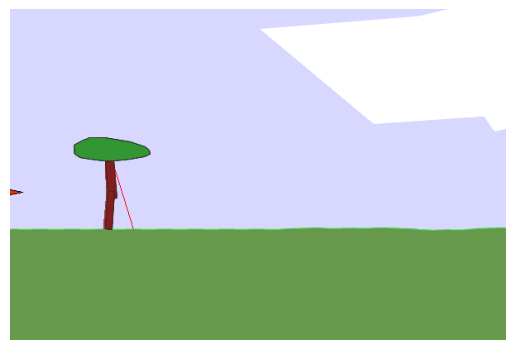

In [4]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
rld.env_info(env, print_out=True)

# render start image (reset just to render image)
env.reset(seed=42)
rld.render(env)

**Collect episodes and train the agent**

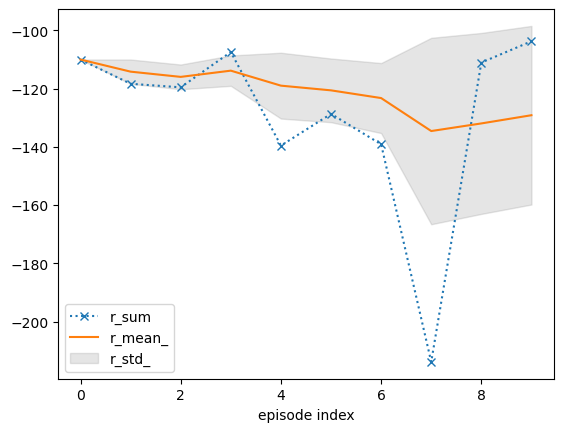

In [5]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env)
max_episodes = 10

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = True                 # usually tracking every episode is fine
    env.video = episode % 100 == 0  # record videos every 100 episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()

    # run episode
    done = False
    while not done:
        
        # select the agent action
        action = agent.sample_action(observation)

        # take action in the environment
        observation, reward, terminated, truncated, info = env.step(action)

        # remember
        agent.put_data(action, observation, reward)

        # check whether done
        done = terminated or truncated

    # train the agent after each episode
    agent.train()
            
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

## Heuristic demo

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (designed for the orignal BipedalWalker environment, but should also work fine for rldurham/Walker).

In [6]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42


## SAC Implementation

This is a Soft-Actor-Critic (SAC) implementation (adapted from https://github.com/seungeunrho/minimalRL/blob/master/sac.py) that does not perform very well, but is a decent starting point for the coursework. It can be outperformed by simpler methods (e.g. TD3) if they are well tuned and you are free to use any other method. Overall, the task is to make use of various ideas and principles that were covered in the lecture and/or that you find in papers to achieve the best possible performance.

In [7]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections, random

In [8]:
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])

        s_lst = np.array(s_lst)
        a_lst = np.array(a_lst)
        r_lst = np.array(r_lst)
        s_prime_lst = np.array(s_prime_lst)
        done_mask_lst = np.array(done_mask_lst)

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

In [9]:
class PolicyNet(nn.Module):
    def __init__(self, learning_rate, act_dim, obs_dim, init_alpha, lr_alpha):
        super(PolicyNet, self).__init__()
        latent_dim = max(128, 2 * obs_dim)
        self.fc1 = nn.Linear(obs_dim, latent_dim)
        self.fc_mu = nn.Linear(latent_dim, act_dim)
        self.fc_std = nn.Linear(latent_dim, act_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.log_alpha = torch.tensor(np.log(init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_alpha)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch, target_entropy):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

In [10]:
class QNet(nn.Module):
    def __init__(self, learning_rate, act_dim, obs_dim):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(obs_dim, 64)
        self.fc_a = nn.Linear(act_dim,64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32, act_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1, h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a), target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target, tau):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [11]:
class Agent(nn.Module):

    def __init__(self,
                 env,
                 lr_pi=0.0005,
                 lr_q=0.001,
                 init_alpha=0.01,
                 buffer_limit=50_000,
                 gamma=0.98,
                 batch_size=128,
                 tau=0.01,  # for target network soft update
                 target_entropy=-1.0,  # for automated alpha update
                 train_steps=100,
                 lr_alpha=0.001,  # for automated alpha update
                 ):
        super().__init__()
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_entropy = target_entropy
        self.train_steps = train_steps

        discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

        self.memory = ReplayBuffer(buffer_limit=buffer_limit)
        self.q1 = QNet(lr_q, act_dim, obs_dim)
        self.q2 = QNet(lr_q, act_dim, obs_dim)
        self.q1_target = QNet(lr_q, act_dim, obs_dim)
        self.q2_target = QNet(lr_q, act_dim, obs_dim)
        self.pi = PolicyNet(lr_pi, act_dim, obs_dim, init_alpha=init_alpha, lr_alpha=lr_alpha)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

    def action(self, s):
        a, log_prob = self.pi(torch.from_numpy(s).float())
        a = a.detach().numpy()
        a *= 2
        # assert np.all(a >= -0.4) and np.all(a <= 0.4)
        return a

    def put(self, s, a, r, s_prime, done):
        self.memory.put((s, a, r / 10.0, s_prime, done))

    def train(self):
        if self.memory.size() > 1000:
            for i in range(self.train_steps):
                mini_batch = self.memory.sample(self.batch_size)
                td_target = self.calc_target(mini_batch)
                self.q1.train_net(td_target, mini_batch)
                self.q2.train_net(td_target, mini_batch)
                self.pi.train_net(self.q1, self.q2, mini_batch, target_entropy=self.target_entropy)
                self.q1.soft_update(self.q1_target, tau=self.tau)
                self.q2.soft_update(self.q2_target, tau=self.tau)

    def calc_target(self, mini_batch):
        s, a, r, s_prime, done = mini_batch

        with torch.no_grad():
            a_prime, log_prob = self.pi(s_prime)
            entropy = -self.pi.log_alpha.exp() * log_prob
            q1_val = self.q1(s_prime, a_prime)
            q2_val = self.q2(s_prime, a_prime)
            q1_q2 = torch.cat([q1_val, q2_val], dim=1)
            min_q = torch.min(q1_q2, 1, keepdim=True)[0]
            target = r + self.gamma * done * (min_q + entropy)

        return target

    def episode(self):
        done = False
        s, _ = self.env.reset()
        info = {}
        while not done:
            a = self.action(s)
            s_prime, r, terminated, truncated, info = self.env.step(a)
            done = terminated or truncated
            self.put(s, a, r, s_prime, done)
            s = s_prime
        return info

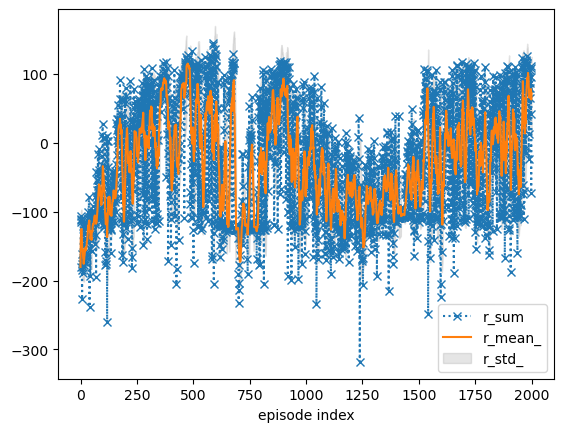

In [12]:
# initialise environment
env = rld.make("rldurham/Walker", render_mode="rgb_array")
rld.seed_everything(42, env)

# set up recording
env = rld.Recorder(env,
                   smoothing=10,
                   video=True)
recorder = env
recorder.video = False
tracker = rld.InfoTracker()

# clip negative rewards (known trick in Walker environment)
env = rld.transparent_wrapper(gym.wrappers.ClipReward)(env, min_reward=-10)

# initialise agent
agent = Agent(env)
agent.target_entropy = 0  # slightly higher entropy to encourage exploration

for n_epi in range(2000):

    recorder.video = (n_epi + 1) % 100 == 0   # record video every 100 episodes
    info = agent.episode()                    # collect episode
    env.add_stats(info, ignore_existing=True) # explicitly add stats in case of early termination
    tracker.track(info)                       # track statistics
    agent.train()                             # train agent

    # update progress every 10 episodes
    if (n_epi + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

env.close()